# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

torch device: cuda


In [3]:
torch.__version__

import warnings

warnings.filterwarnings('ignore')

'1.13.0'

### Style settings

In [4]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
#plt.rcParams['image.cmap'] = 'emct8'
#plt.rcParams['image.cmap'] = 'warm'
#plt.rcParams['image.cmap'] = 'twilight'
#plt.rcParams['image.cmap'] = 'coolwarm'
#plt.rcParams['image.cmap'] = 'RdYlBu_r'
        

# Functions

In [5]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

In [6]:
def poly_bead_rmsd(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0)
    rmsd = torch.zeros(Ttot, device=device)
    for i in range(1,Ttot):
        tdiff_mat = (tcom_arr[:,:,i:] - pol_com[:,i:]) - (tcom_arr[:,:,:-i] - pol_com[:,:-i])
        rmsd[i] = torch.einsum('ijk,ijk->', tdiff_mat, tdiff_mat)/((Ttot-i)*n)
        
    return rmsd


In [7]:
def poly_autocorr(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    n = com_arr.shape[0]
    Ttot = com_arr.shape[-1]
    pol_com = tcom_arr.mean(axis=0).to(device)
    autocorr = torch.zeros(Ttot, device=device)
    autocorr[0] = torch.einsum('ijk,ijk->ik', 
                                (tcom_arr[:,:,:] - pol_com[:,:]), 
                            (tcom_arr[:,:,:] - pol_com[:,:])).mean()
    for i in tqdm(list(range(1,Ttot))):
        autocorr[i] = torch.einsum('ijk,ijk->ik', 
                                    (tcom_arr[:,:,i:] - pol_com[:,i:]), 
                                (tcom_arr[:,:,:-i] - pol_com[:,:-i])).mean()
        
    return autocorr


In [17]:
def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    # pol_com = tcom_arr.mean(axis=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    # f = torch.fft.fftn(tcom_arr, s=[2 * n], dim=[-1], norm='forward')
    f = torch.fft.fftn(tcom_arr, dim=[-1], norm='forward')
    # f = torch.fft.fftn(tcom_arr,  dim=[-1] )
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    # print(f'nsteps = {nsteps}')
    # print(f'autocorr size = {autocorr.size()}')
    return autocorr.mean(dim=0)
        


In [9]:
def power_spec(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    # pol_com = tcom_arr.mean(axis=0).to(device)
    nsteps = tcom_arr.shape[-1]
    n = next_pow_two(nsteps)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr, s=[2 * n], dim=[-1])
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))[:,:nsteps].real
    # f = torch.fft.fftn(tcom_arr, s=[2 * n], dim=[-1])
    return power_spec
        


In [10]:
def sep_autocorr(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    n = tsep_mat.shape[0]
    Ttot = tsep_mat.shape[-1]
    tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
    avg_tsep_mat = tsep_mat.mean(dim=(0,1)).to(device)
    avg_sep = avg_tsep_mat.mean()
    for i in range(1,tsep_mat.shape[-1]):
        tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
    # del avg_tsep_mat
    # del tsep_mat
    # del tcom_arr
        
    return tcorr_d


In [11]:
def autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    t0 = time.time()
    tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2).to(device)
    t1 = time.time()
    print(f'tsep_mat = {t1-t0}')
    nsteps = tsep_mat.shape[-1]
    n = next_pow_two(nsteps)
    t2 = time.time()
    print(f'power of two = {t2-t1}')

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tsep_mat, s=[2 * n], dim=[-1])
    t3 = time.time()
    print(f'fft = {t3-t2}')
    autocorr = torch.fft.ifftn(torch.einsum('ijk,ijk->ik', f,
                                       torch.conjugate(f)),
                             dim=[-1])[:,:nsteps].real
    t4 = time.time()
    print(f'ifft = {t4-t3}')

    autocorr /= 4 * n
    return autocorr


In [12]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

# Data generation

In [14]:
# Sim params
part_num=5000
t_tot = 120
dt = .0002
t_snap = .02
# Physical params
kbT = 1.
k = .25
drag_coeff = 1.25
dims = 3
# Derived params
n_steps = int(t_tot/dt)
snap_steps = int(t_snap/dt)
n_snaps = int(n_steps/snap_steps)
mob_coeff = 1./drag_coeff
tau = drag_coeff / k
std = np.sqrt(2.*kbT*drag_coeff*dt)


In [ ]:

print(f'Total steps = {n_steps}')
print(f'Snap steps  = {snap_steps}')
print(f'Total snap shots  = {n_snaps}')

# Create array for data
data_arr = torch.zeros((part_num, dims, n_snaps), device=device)

# Initialize all the particles at (0,0,0)
step_pos_arr = torch.zeros((part_num, dims), device=device)
 
# Make loop for time
for i in tqdm(range(1, n_steps)):
    # Calculate force on all the particles base on positions
    center_force = -k * step_pos_arr
    # center_force = 0
    # Create thermal kicks by generating gaussian noise matrix
    therm_motion = torch.normal(0, std, size=(part_num, dims)).to(device)
    # Update positions
    step_pos_arr += mob_coeff * (center_force*dt + therm_motion)
    # if snapshot time, record data in data matrix
    if i % snap_steps == 0:
        data_arr[:,:,int(i/snap_steps)] = step_pos_arr
        

# Save data to file
with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'w') as h5_data:
    h5_data.create_dataset('pos', data=data_arr.to('cpu'))
    h5_data.create_dataset('time', data=np.arange(0,t_tot, t_snap))


In [ ]:
# # Sim params
# part_num=10000
# t_tot = 20
# dt = .0001
# t_snap = .0
# # Physical params
# kbT = 1.
# k = .25
# # Derived params
# n_steps = int(t_tot/dt)
# snap_steps = int(t_snap/dt)
# n_snaps = int(n_steps/snap_steps)
# drag_coeff = 3.
# mob_coeff = 1./drag_coeff
# tau = drag_coeff / k
# std = np.sqrt(2.*kbT*drag_coeff)

# print(f'Total steps = {n_steps}')
# print(f'Snap steps  = {snap_steps}')
# print(f'Total snap shots  = {n_snaps}')

# # Create array for data
# data_arr = np.zeros((part_num, 3, n_snaps))

# # Initialize all the particles at (0,0,0)
# step_pos_arr = np.zeros((part_num, 3))
 
# # Make loop for time
# for i in tqdm(range(1, n_steps)):
#     # Calculate force on all the particles base on positions
#     center_force = -k * step_pos_arr
#     # center_force = 0
#     # Create thermal kicks by generating gaussian noise matrix
#     therm_force = np.random.normal(0, std, size=(part_num, 3))
#     # Update positions
#     step_pos_arr += mob_coeff * (center_force + therm_force)
#     # if snapshot time, record data in data matrix
#     if i % snap_steps == 0:
#         data_arr[:,:,int(i/snap_steps)] = step_pos_arr
        

# # # Save data to file
# # with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'w') as h5_data:
# #     h5_data.create_dataset('pos', data=data_arr.to('cpu'))
# #     h5_data.create_dataset('time', data=np.arange(0,t_tot, t_snap))




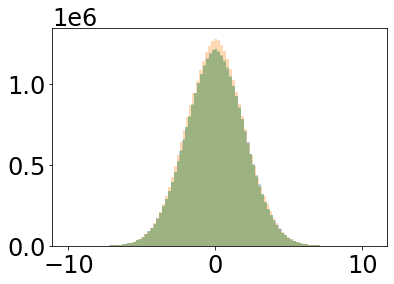

In [22]:
with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    data_arr = h5_data['pos'][:,:,:] 
    _ = plt.hist(data_arr[:,0,:].flatten(), bins=100, alpha=.3)
    _ = plt.hist(data_arr[:,1,:].flatten(), bins=100, alpha=.3)
    _ = plt.hist(data_arr[:,2,:].flatten(), bins=100, alpha=.3)
# plt.hist(data_arr[0,0,:].to('cpu'))
# plt.hist(data_arr[0,0,:].to('cpu').T)
# plt.hist(data_arr[0,1,:].to('cpu'))
# plt.hist(data_arr[0,2,:].to('cpu'))

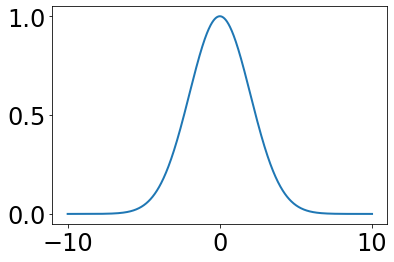

In [20]:
x = np.linspace(-10., 10., 1000)
y = np.exp(-.5 * k * np.power(x,2))
plt.plot(x,y)

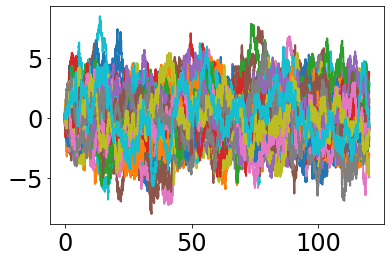

In [91]:
_ = plt.plot(np.arange(0,t_tot, t_snap), data_arr[::100,2, :].T)

NameError: name 'kbT' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


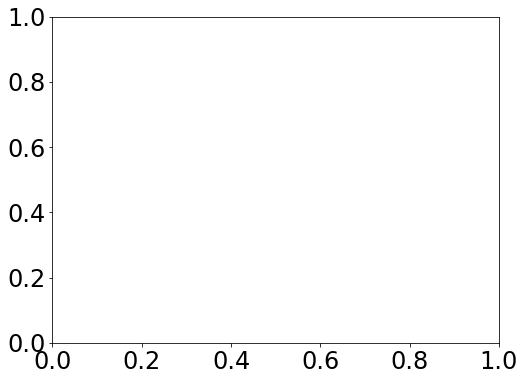

In [13]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    print(3.*kbT/k)
    for i in np.power(2, np.arange(5,13)):
        time_arr = h5_data['time'][:i]
        pos_arr = h5_data['pos'][:,:,:i]
        corr_fast_arr = poly_autocorr_fast(pos_arr)
        x = (3*kbT/k) * np.exp(-time_arr/tau)
        print(corr_fast_arr[0])
        # print(corr_arr.size())
        # _ = axarr.scatter(time_arr, (corr_fast_arr/corr_arr).to('cpu'))
        _ = axarr.scatter(time_arr, corr_fast_arr.to('cpu'))
        _ = axarr.scatter(time_arr, x, color='k')
        _ = axarr.set_yscale('log')
        

    
    
    

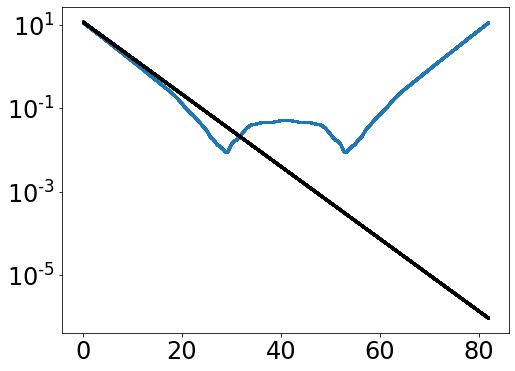

In [18]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    time_arr = h5_data['time'][:4095]
    pos_arr = h5_data['pos'][:,:,:4095]
    corr_fast_arr = poly_autocorr_fast(pos_arr)
    x = (3*kbT/k) * np.exp(-time_arr/tau)
    # print(corr_arr.size())
    # _ = axarr.scatter(time_arr, (corr_fast_arr/corr_arr).to('cpu'))
    _ = axarr.scatter(time_arr, corr_fast_arr.to('cpu'))
    _ = axarr.scatter(time_arr, x, color='k')
    _ = axarr.set_yscale('log')
        

    
    
    

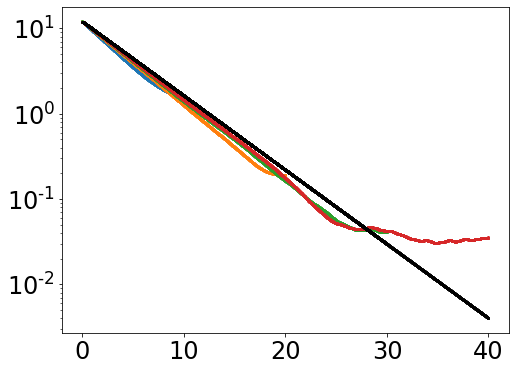

In [24]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    for i in range(1000,5000,1000):
        i_valid = int(i/2)
        time_arr = h5_data['time'][:i_valid]
        pos_arr = h5_data['pos'][:,:,-i:]
        corr_fast_arr = poly_autocorr_fast(pos_arr)
        x = (3*kbT/k) * np.exp(-time_arr/tau)
        # print(corr_arr.size())
        # _ = axarr.scatter(time_arr, (corr_fast_arr/corr_arr).to('cpu'))
        _ = axarr.scatter(time_arr, corr_fast_arr.to('cpu')[:i_valid])
        _ = axarr.scatter(time_arr, x, color='k')
        _ = axarr.set_yscale('log')
        

    
    
    

  0%|          | 0/999 [00:00<?, ?it/s]

  0%|          | 0/1999 [00:00<?, ?it/s]

  0%|          | 0/2999 [00:00<?, ?it/s]

  0%|          | 0/3999 [00:00<?, ?it/s]

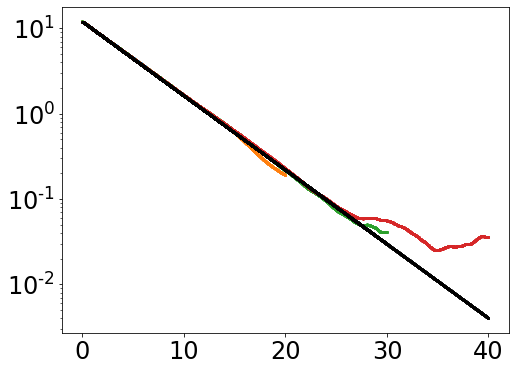

In [25]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    for i in range(1000,5000,1000):
        i_valid = int(i/2)
        time_arr = h5_data['time'][:i_valid]
        pos_arr = h5_data['pos'][:,:,-i:]
        corr_arr = poly_autocorr(pos_arr)
        x = (3*kbT/k) * np.exp(-time_arr/tau)
        # print(corr_arr.size())
        # _ = axarr.scatter(time_arr, (corr_fast_arr/corr_arr).to('cpu'))
        _ = axarr.scatter(time_arr, corr_arr.to('cpu')[:i_valid])
        _ = axarr.scatter(time_arr, x, color='k')
        _ = axarr.set_yscale('log')
        

    
    
    

  0%|          | 0/4999 [00:00<?, ?it/s]

torch.Size([5000])


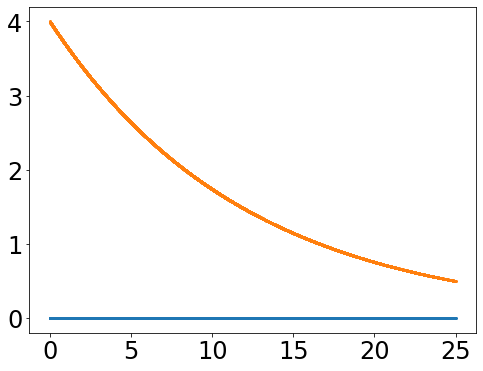

In [57]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    time_arr = h5_data['time'][:-1000]
    pos_arr = h5_data['pos'][:,:,1000:]
    corr_arr = poly_autocorr(pos_arr)
    x = (kbT/k) * np.exp(-time_arr/tau)
    print(corr_arr.size())
    _ = axarr.scatter(time_arr, corr_arr.to('cpu'))
    _ = axarr.scatter(time_arr, x)
    

    
    
    

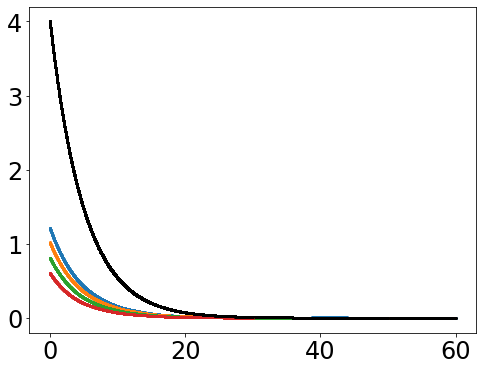

In [119]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    for i in range(3000,5000,500):
        time_arr = h5_data['time'][:-i]
        pos_arr = h5_data['pos'][:,:,i:]
        n_parts = 1000
        corr_list = []
        for i in range(n_parts):
            corr_arr = correlate(pos_arr[i,0,:], pos_arr[i,0,:])
            n = corr_arr.size
            corr_arr = corr_arr[int(.5*n):]
            corr_list += [corr_arr]
            n = corr_arr.size
        x = (kbT/k) * np.exp(-time_arr/tau)
        # print(corr_arr.size())
        corr_avg  = np.mean(corr_list, axis=0)
        # _ = axarr.plot(corr_arr)
        _ = axarr.scatter(time_arr[:n], corr_avg)
        _ = axarr.scatter(time_arr, x, color='k')
    
    
    
    

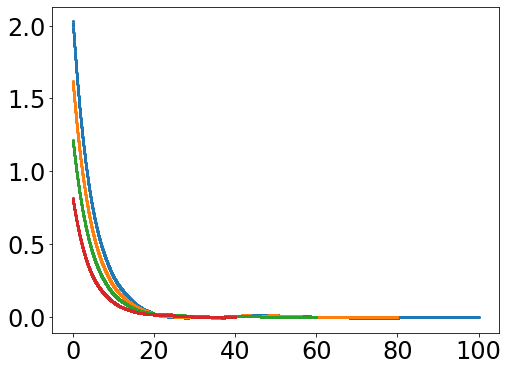

In [120]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    for i in range(1000,5000,1000):
        time_arr = h5_data['time'][:-i]
        pos_arr = h5_data['pos'][:,:,i:]
        n_parts = 1000
        corr_list = []
        for i in range(n_parts):
            corr_arr = fftconvolve(pos_arr[i,0,:], pos_arr[i,0,::-1], mode='full')
            # corr_arr = correlate(pos_arr[i,0,:], pos_arr[i,0,:])
            n = corr_arr.size
            corr_arr = corr_arr[int(.5*n):]
            corr_list += [corr_arr]
            n = corr_arr.size
        x = (kbT/k) * np.exp(-time_arr/tau)
        # print(corr_arr.size())
        corr_avg  = np.mean(corr_list, axis=0)
        # _ = axarr.plot(corr_arr)
        _ = axarr.scatter(time_arr[:n], corr_avg)
        # _ = axarr.scatter(time_arr, x)

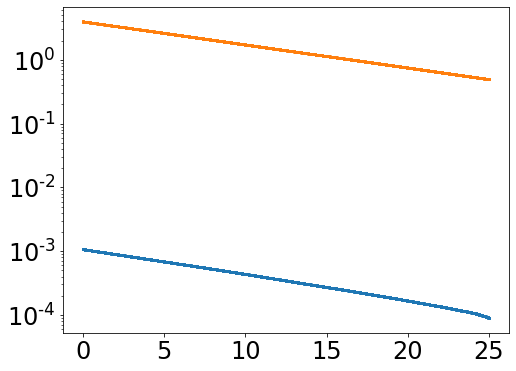

In [58]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    time_arr = h5_data['time'][:-1000]
    pos_arr = h5_data['pos'][:,:,1000:]
    # corr_arr = poly_autocorr(pos_arr)
    # x = (kbT/k) * np.exp(-time_arr/tau)
    # print(corr_arr.size())
    _ = axarr.scatter(time_arr, corr_arr.to('cpu'))
    _ = axarr.scatter(time_arr, x)
    _ = axarr.set_yscale('log')
    

    
    
    

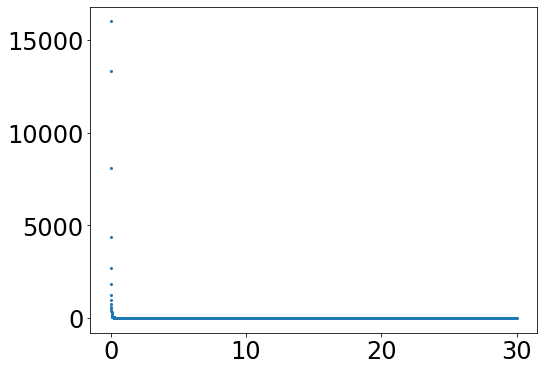

In [40]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File(Path.cwd() / 'corr_harm_well_test.h5', 'r') as h5_data:
    time_arr = h5_data['time'][...]
    pos_arr = h5_data['pos'][...]
    corr_arr = power_spec(pos_arr).mean(dim=0)
    _ = axarr.scatter(time_arr[:], corr_arr.to('cpu')[:])
    
    

    
    
    

# Single seeds

# Seed scan

AssertionError: 

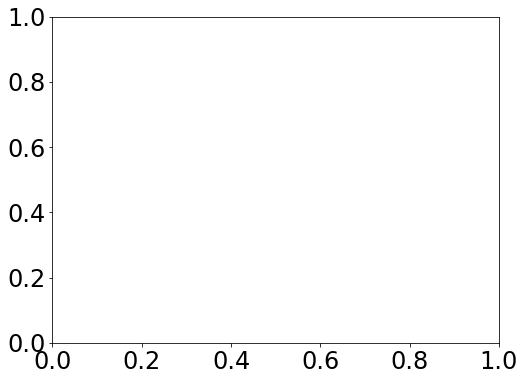

In [84]:
data_path = (ceph_path /"22_aLc800_sticky_runs/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = None
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

            auto_corr_list += [poly_autocorr(com_arr)]
            _ = axarr.scatter(time_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    auto_corr_list = np.array([avg[:min_length] for avg in auto_corr_list])
    
        
    _ = axarr.plot(time_arr[:min_length], np.array(auto_corr_list).mean(axis=0), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    # _ = axarr.set_yscale('log')
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

  0%|          | 0/12 [00:00<?, ?it/s]

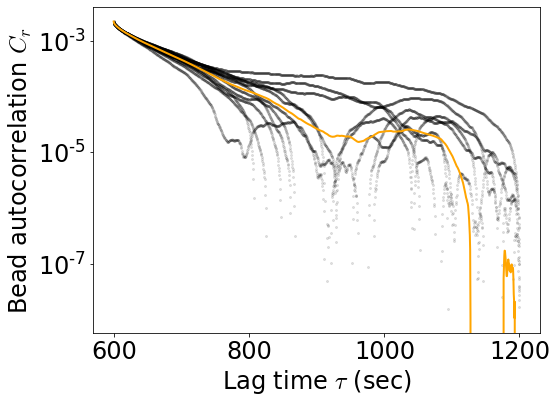

In [64]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = None
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in tqdm(seed_paths):
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

            auto_corr_list += [poly_autocorr_fast(com_arr)[:,:time_arr.size].mean(dim=0)]
            _ = axarr.scatter(time_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    avg_auto_corr = torch.stack([avg[:min_length] for avg in auto_corr_list]).mean(dim=0)
    
    _ = axarr.plot(time_arr[:min_length], avg_auto_corr, color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

  0%|          | 0/12 [00:00<?, ?it/s]

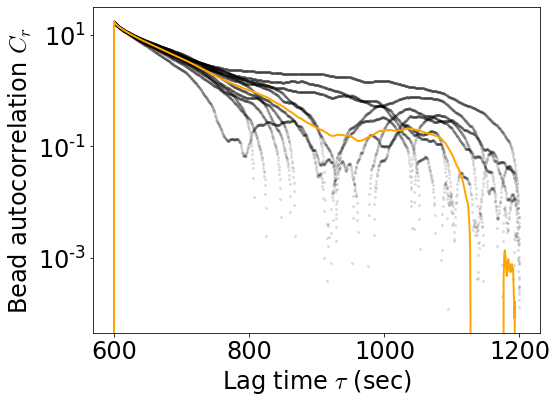

In [71]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = None
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in tqdm(seed_paths):
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

            auto_corr_list += [poly_autocorr(com_arr) ]
            _ = axarr.scatter(time_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    avg_auto_corr = torch.stack([avg[:min_length] for avg in auto_corr_list]).mean(dim=0)
    
        
    _ = axarr.plot(time_arr[:min_length], avg_auto_corr, color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

  0%|          | 0/12 [00:00<?, ?it/s]

tensor([0.0151, 0.0142, 0.0139,  ..., 0.0001, 0.0005, 0.0008])
tensor([2.2124e-03, 2.0848e-03, 2.0331e-03,  ..., 3.9204e-08, 1.0995e-07,
        9.8846e-08])
tensor([6.8153e+00, 6.8210e+00, 6.8267e+00,  ..., 2.7304e+03, 4.0956e+03,
        8.1911e+03])
tensor([ 0.0151,  0.0142,  0.0139,  ..., -0.0002, -0.0003, -0.0006])
tensor([ 2.2169e-03,  2.0890e-03,  2.0364e-03,  ..., -5.6686e-08,
        -7.8855e-08, -7.5755e-08])
tensor([6.8153e+00, 6.8210e+00, 6.8267e+00,  ..., 2.7310e+03, 4.0968e+03,
        8.1936e+03])
tensor([ 0.0150,  0.0142,  0.0138,  ..., -0.0010, -0.0009, -0.0008])
tensor([ 2.2045e-03,  2.0767e-03,  2.0240e-03,  ..., -3.6930e-07,
        -2.2831e-07, -9.6890e-08])
tensor([6.8153e+00, 6.8210e+00, 6.8267e+00,  ..., 2.7307e+03, 4.0962e+03,
        8.1926e+03])
tensor([0.0150, 0.0142, 0.0138,  ..., 0.0014, 0.0011, 0.0011])
tensor([2.2066e-03, 2.0787e-03, 2.0265e-03,  ..., 5.1402e-07, 2.7392e-07,
        1.3030e-07])
tensor([6.8153e+00, 6.8210e+00, 6.8267e+00,  ..., 2.7306e+0

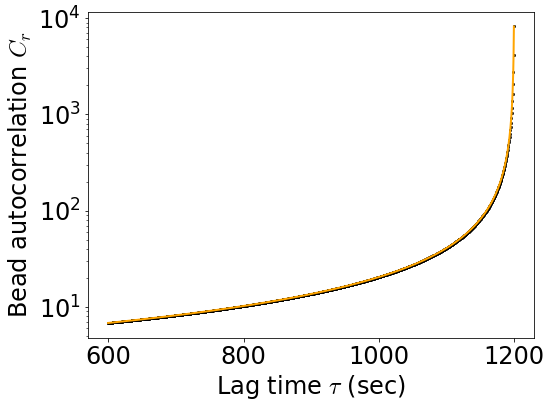

In [78]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = None
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in tqdm(seed_paths):
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            time_arr = h5_data['time'][ss_ind:end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            ac = poly_autocorr(com_arr)
            fast_ac = poly_autocorr_fast(com_arr)[:,:time_arr.size].mean(dim=0)
            print(ac)
            print(fast_ac)
            print(ac / fast_ac)
            auto_corr_list += [ac / fast_ac]
            # print(auto_corr_list[-1])
            _ = axarr.scatter(time_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    avg_auto_corr = torch.stack([avg[:min_length] for avg in auto_corr_list]).mean(dim=0)
    
        
    _ = axarr.plot(time_arr[:min_length], avg_auto_corr, color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

In [5]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    tcorr_d_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            tcom_arr = torch.from_numpy(com_arr).to(device)
            tsep_mat = (tcom_arr[:, None, :,:] - tcom_arr[None, :, :,:]).norm(dim=2)
            n = tsep_mat.shape[0]
            Ttot = tsep_mat.shape[-1]
            tcorr_d = torch.zeros(tsep_mat.shape[-1], device=device)
            avg_tsep_mat = tsep_mat.mean(dim=(0,1))
            avg_sep = avg_tsep_mat.mean()
            for i in tqdm(range(1,tsep_mat.shape[-1])):
                    tcorr_d[i] = ((tsep_mat[:,:,i:] - avg_tsep_mat[i:]) * (tsep_mat[:,:,:-i]-avg_tsep_mat[:-i])).sum()/(n*n*avg_sep*avg_sep*(Ttot-i))
            tcorr_d_list += [tcorr_d]

            _ = axarr.scatter(lag_arr, tcorr_d_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in tcorr_d_list])
    tcorr_d_avg = torch.stack([arr[:min_length] for arr in tcorr_d_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], tcorr_d_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
        
except:
    raise

  0%|          | 0/759 [00:00<?, ?it/s]

  0%|          | 0/787 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/769 [00:00<?, ?it/s]

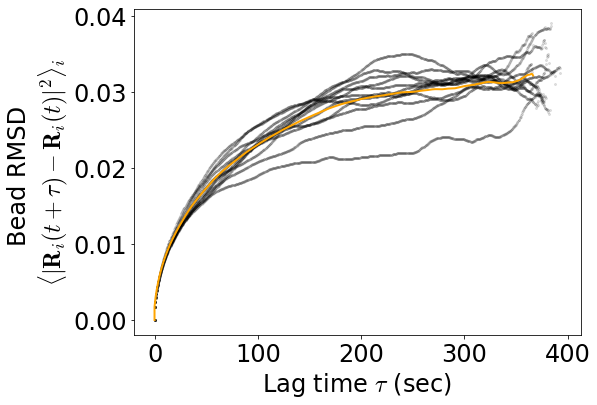

In [34]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    rmsd_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rmsd_list += [poly_bead_rmsd(com_arr)]

            _ = axarr.scatter(lag_arr, rmsd_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in rmsd_list])
    rmsd_avg = torch.stack([arr[:min_length] for arr in rmsd_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], rmsd_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


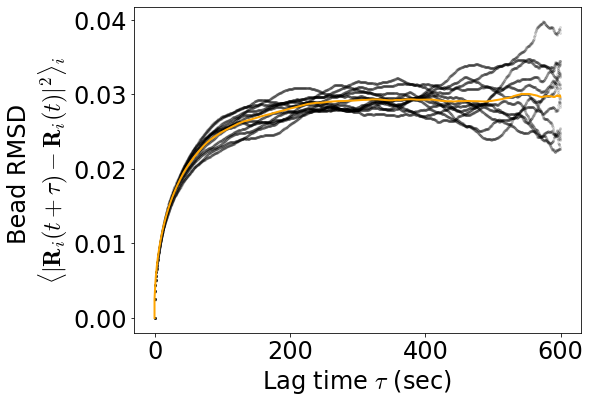

In [8]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    rmsd_list = []
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rmsd_list += [poly_bead_rmsd(com_arr)]

            _ = axarr.scatter(lag_arr, rmsd_list[-1].cpu(), color='k',alpha=.1)

    min_length = min([arr.shape[-1] for arr in rmsd_list])
    rmsd_avg = torch.stack([arr[:min_length] for arr in rmsd_list]).mean(dim=0)
    
    
        
    _ = axarr.plot(lag_arr[:min_length], rmsd_avg.cpu(), color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead RMSD \n' + r'$\langle |{\bf R}_i(t+\tau)- {\bf R}_i(t)|^2 \rangle_i$')
        
except:
    raise

[0.72402419 0.01522212]


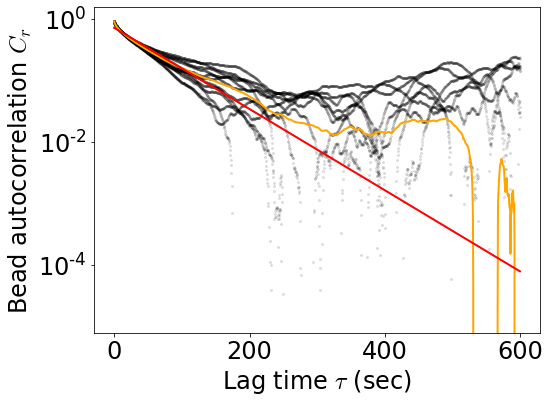

In [57]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations/kod30")
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None

auto_corr_list = []
try:
    seed_paths = [path for path in data_path.glob('**/s*') if path.is_dir()]
    assert seed_paths
    
    for sp in seed_paths:
        with h5py.File(next(sp.glob('analysis/raw*.h5')), 'r+') as h5_data:
            lag_arr = h5_data['time'][:-ss_ind+end_ind]

            sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                                :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0)

            auto_corr_list += [poly_autocorr(com_arr)]
            _ = axarr.scatter(lag_arr, auto_corr_list[-1], color='k',alpha=.1)

    min_length = min([len(avg) for avg in auto_corr_list])
    auto_corr_list = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
    _ = axarr.plot(lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:], color='orange')
    _ = axarr.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr.set_ylabel('Bead autocorrelation $C_r$')
    _ = axarr.set_yscale('log')
    params, cv = curve_fit(monoExp, lag_arr[1:min_length], auto_corr_list.mean(axis=0)[1:])
    _ = axarr.plot(lag_arr[1:min_length], monoExp(lag_arr[1:min_length], *params), color='r')
    print(params)
    # _ = axarr[1].plot(time_arr, np.array(avg_total_bead).mean(axis=0), color='orange')
    
    # _ = axarr[0].set_title('Number of clusters')
    # _ = axarr[1].set_title('Total beads in clusters')

    # _ = axarr[0].set_ylim(0)
    # _ = axarr[1].set_ylim(0)
        
except:
    raise

# Param-seed scan

## Pinned scans

In [8]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf")

param_paths = [path for path in data_path.glob('simulations/kod*/') if path.is_dir()]
for pp in param_paths:
    anal_path = data_path /f'analysis/{pp.name}'
    _ = anal_path.mkdir(exist_ok=True)
    with h5py.File(anal_path / f'{pp.name}_sd_scan.h5', 'w') as h5_data:
        time_arr, seed_cluster_num, seed_total_bead  = get_sd_scan_cluster_num_and_bead_lst(pp)
        _ = h5_data.create_dataset('time', data=time_arr)
        _ = h5_data.create_dataset('sd_cluster_num', data=seed_cluster_num)
        _ = h5_data.create_dataset('sd_total_cluster_bead_num', data=seed_total_bead)





kod1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod1
kod0.1
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.1
kod100
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod100
kod3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod3
kod30
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod30
kod300
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod300
kod0.3
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod0.3
kod10
/mnt/home/alamson/ceph/DATA/Chromatin/22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/simulations/kod10


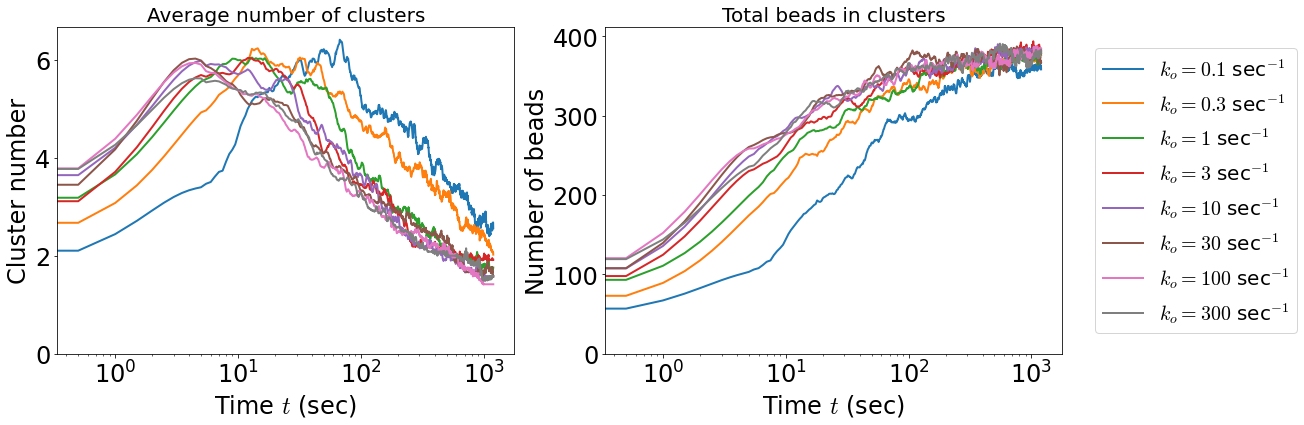

In [ ]:
data_path = (ceph_path /"22-08-12_aLc1_scan8.12_line800_sticky55nm_ko.1-300_5umconf/analysis")
fig, axarr = plt.subplots(1,2, figsize=(18,6))
mp = re.compile('kod(\d*\.?\d+)')

param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
for pdir in param_dirs:
    with h5py.File(next(pdir.glob('*sd_scan.h5')), 'r') as h5_data:
        time_arr = h5_data['time'][...]
        sd_cluster_num = h5_data['sd_cluster_num'][...]
        sd_total_cluster_bead_num = h5_data['sd_total_cluster_bead_num'][...]
        label = re.split(r'(^[^\d]+)',str(pdir.name))[1:][1]
    
    
        
    _ = axarr[0].plot(time_arr, savgol_filter(np.array(sd_cluster_num).mean(axis=0), 21, 3))
    # _ = axarr[1].plot(time_arr, np.array(sd_total_cluster_bead_num).mean(axis=0), label=f"$k_o = {label}$ sec$^{{-1}}$")
    _ = axarr[1].plot(time_arr, savgol_filter(np.array(sd_total_cluster_bead_num).mean(axis=0), 21, 3), label=f"$k_o = {label}$ sec$^{{-1}}$")

_ = axarr[0].set_title('Average number of clusters')
_ = axarr[1].set_title('Total beads in clusters')

_ = axarr[0].set_ylabel('Cluster number')
_ = axarr[1].set_ylabel('Number of beads')


for ax in axarr:
    _ = ax.set_xscale('log')
    _ = ax.set_ylim(0)
    _ = ax.set_xlabel('Time $t$ (sec)')
_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


## $K_e$ scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


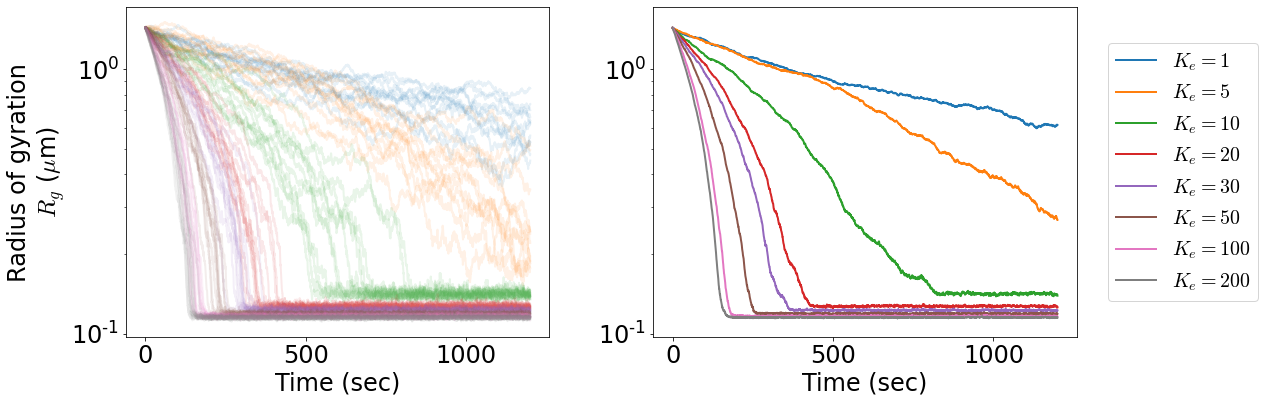

In [9]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

In [14]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [9]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):
            t0 = time.time()
            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            t1 = time.time()
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            print(f'com load time = {t1-t0}')
            n_beads = com_arr.shape[0]
            auto_corr_list += [autocorr_fast(com_arr)]
            t2 = time.time()
            print(f'autocorr time = {t2-t1}')
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r' $C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

com load time = 0.02950906753540039


0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

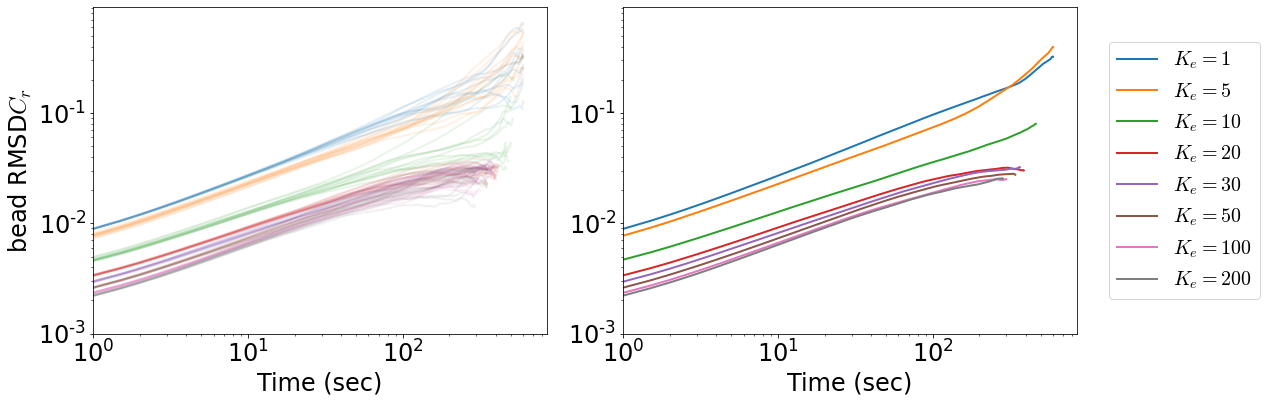

In [ ]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1200
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ K_e = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD ' + r' $\langle \Delta R(t)\rangle$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $k_o$ scans

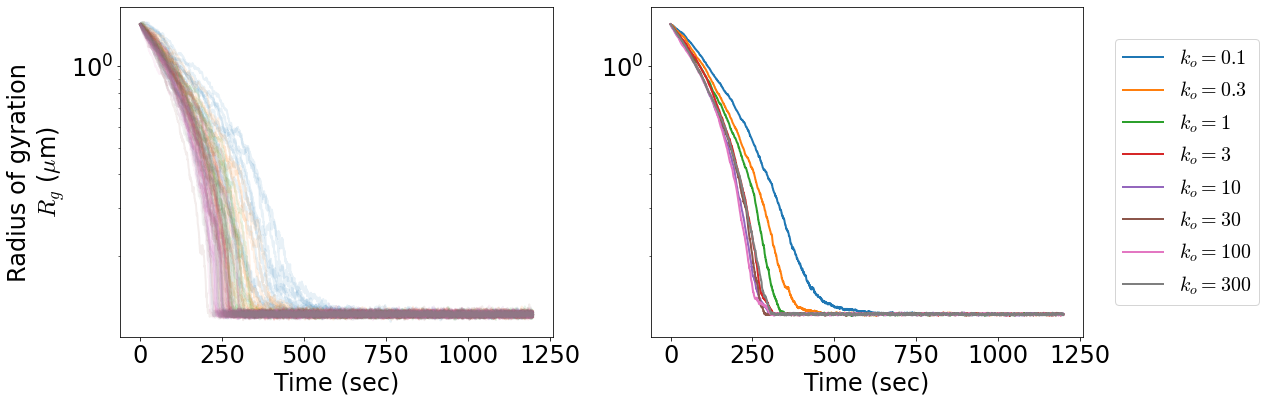

In [14]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in enumerate(param_dirs):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


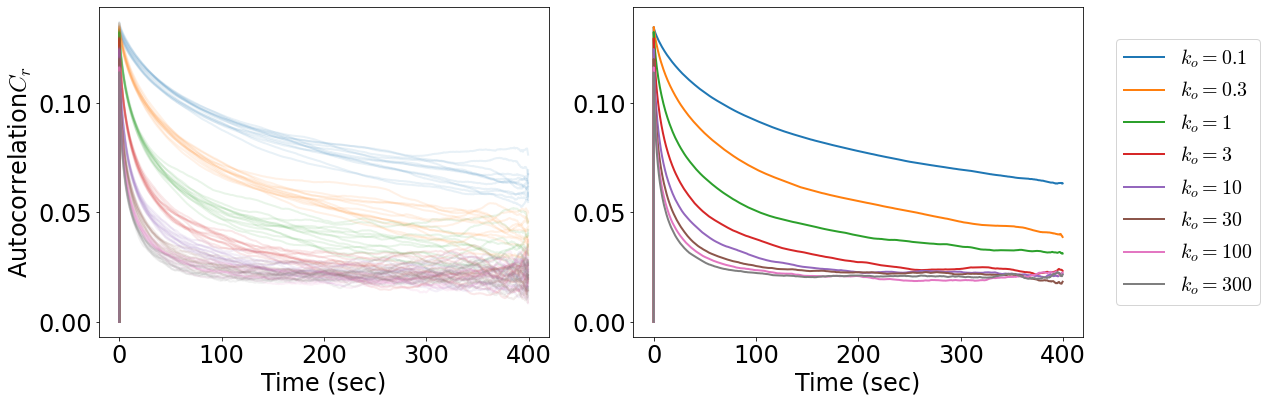

In [7]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

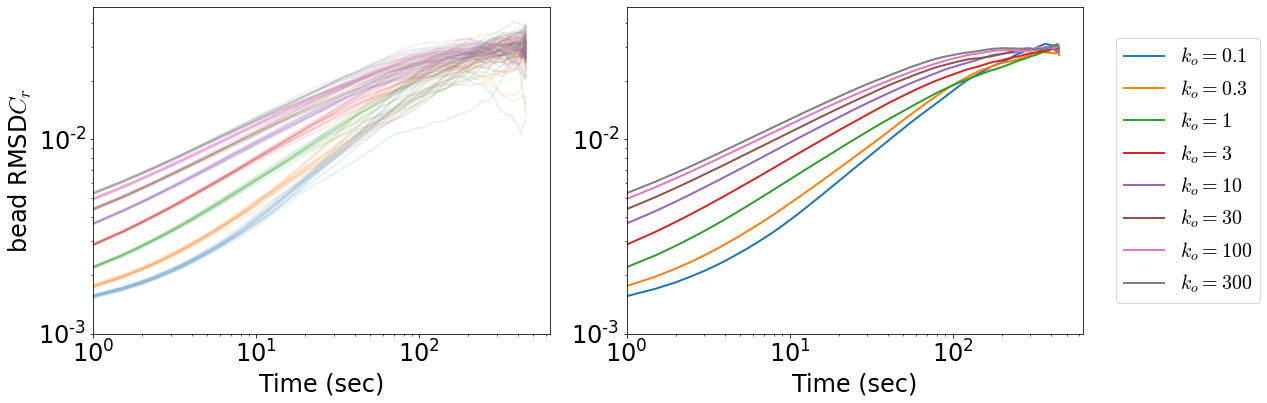

In [68]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.001)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## Rheology calculations

0it [00:00, ?it/s]

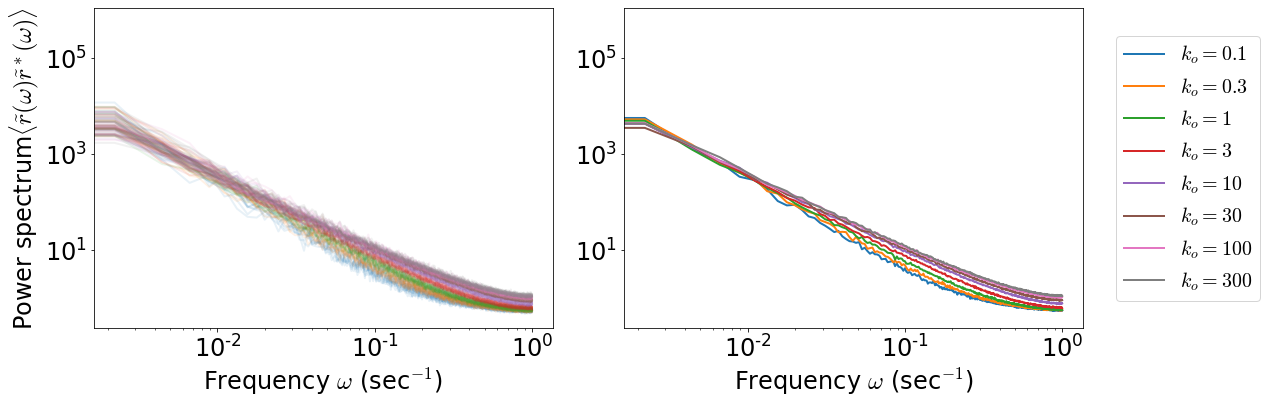

In [67]:
# torch.cuda.empty_cache()
# gc.collect()
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Power spectrum' + r'$\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle$')
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

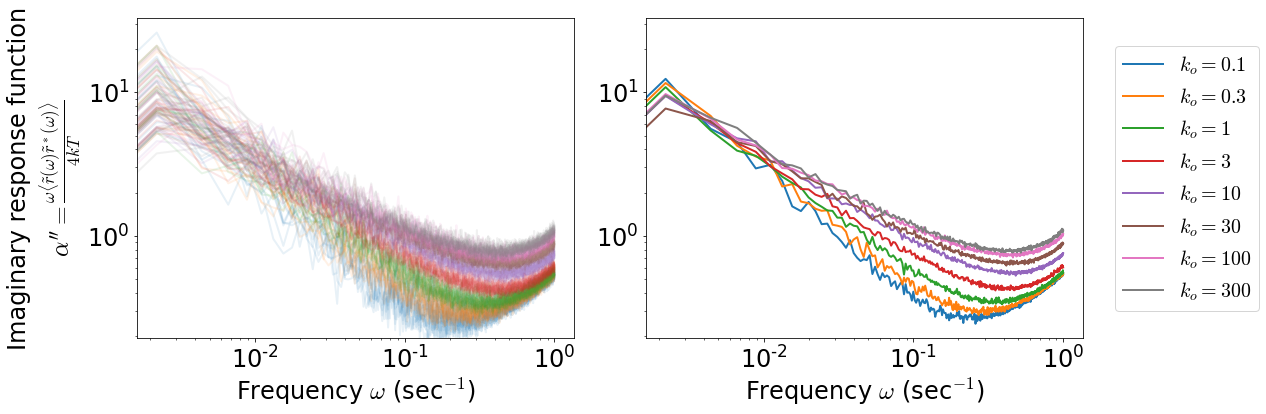

In [65]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_power_spec_list = []
    std_auto_corr_list = []
    fft_avg_rmsd_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            power_spec_list[-1]*=freqs
            _ = axarr1[0].plot(freqs, power_spec_list[-1].cpu(), color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in power_spec_list])
        power_spec_mat = torch.stack([avg[:min_length] for avg in power_spec_list])
        
        avg_power_spec_list += [power_spec_mat.mean(axis=0)]
        std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_power_spec_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Imaginary response function\n' + r"$\alpha'' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

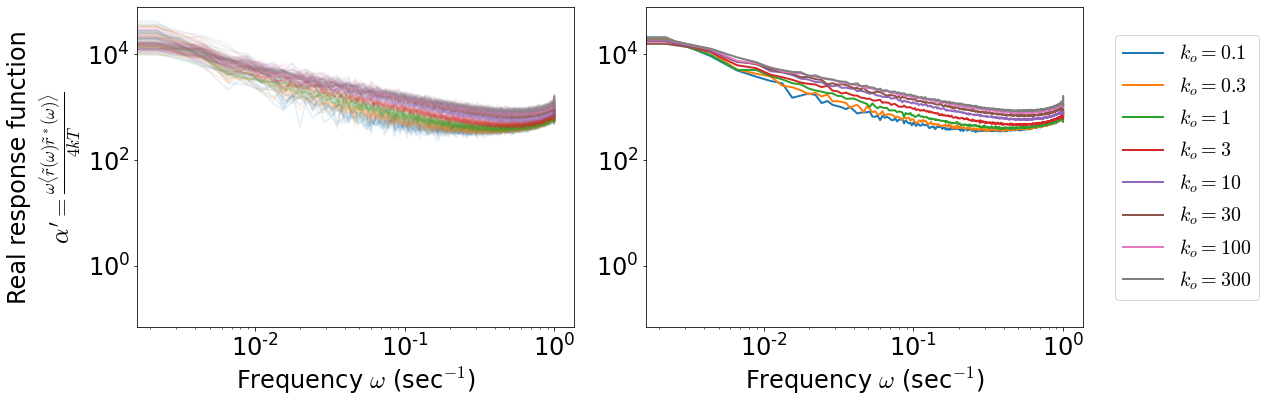

In [ ]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_real_resp_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        im_resp_list = []
        real_resp_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1)
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp_list += [freqs * power_spec_list[-1]]
            real_resp_list += [(2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp_list[-1].cpu().numpy())
                )
            )]

            _ = axarr1[0].plot(freqs, real_resp_list[-1], color=colors[i], alpha=.1)
            _ = real_resp_list[-1].to(device)

        min_length = min([len(avg) for avg in real_resp_list])
        real_resp_mat = torch.stack([avg[:min_length] for avg in real_resp_list])
        
        avg_real_resp_list += [real_resp_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[1].plot(freqs, (avg_real_resp_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0].set_ylabel('Real response function\n' + r"$\alpha' = \frac{\omega\langle \tilde{r}(\omega)\tilde{r}^*(\omega)\rangle}{4kT}$")
    _ = axarr1[0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

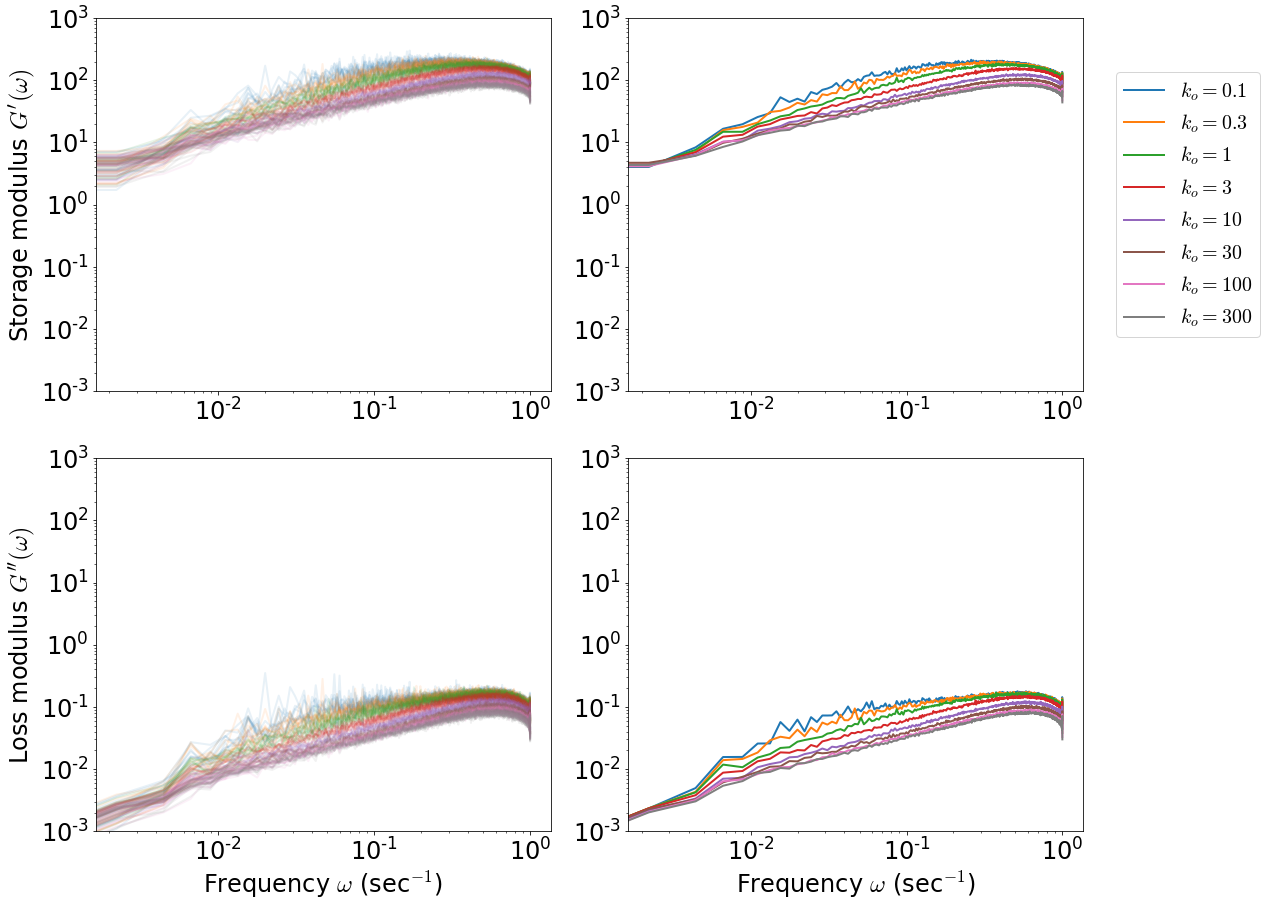

In [75]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

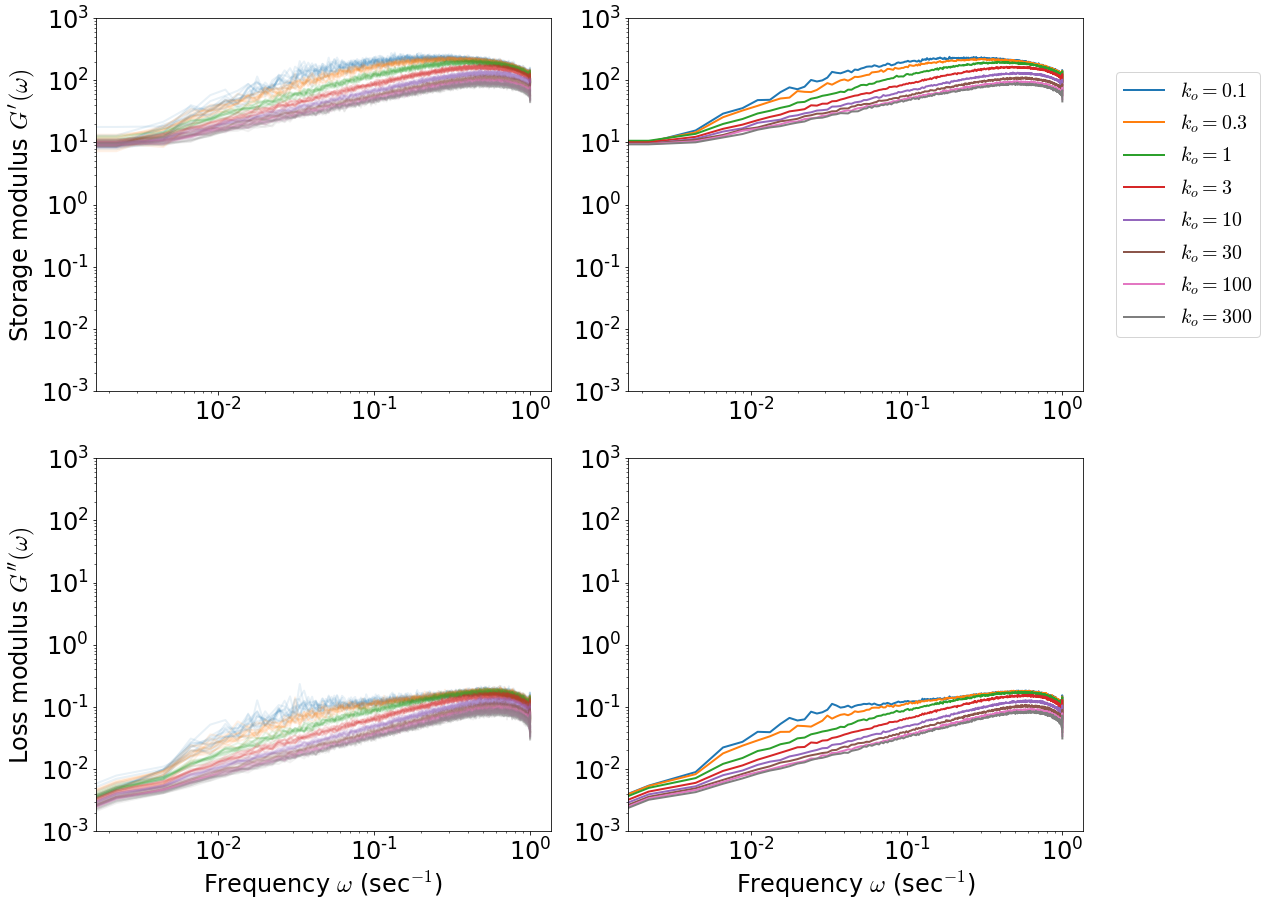

In [78]:

data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1500
end_ind = -1
start_bead = 0
end_bead = None
bead_rad = .01
try:
    fig1, axarr1 = plt.subplots(2, 2, figsize=(18, 13))
    axarr1[0,0].sharey(axarr1[0,1])
    axarr1[0,0].sharex(axarr1[0,1])
    axarr1[1,0].sharey(axarr1[1,1])
    axarr1[1,0].sharex(axarr1[1,1])
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_stor_mod_list = []
    avg_loss_mod_list = []
    pre_fact = 1./(6.*np.pi*bead_rad)
    for i, pd in tqdm(enumerate(param_dirs)):
        power_spec_list = []
        stor_mod_list = []
        loss_mod_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            com_arr -= com_arr.mean(axis=0) 
            fft = torch.fft.fft(torch.from_numpy(com_arr).to(device), dim=-1, norm='forward')
            power_spec = torch.einsum('ijk,ijk->ik', fft, torch.conj(fft)) 
            n_beads = com_arr.shape[0]

            power_spec_list += [torch.fft.fftshift(power_spec.mean(axis=0))]
            freq = torch.fft.fftfreq(power_spec_list[-1].size(dim=0), time_arr[2]-time_arr[1])
            freqs = torch.fft.fftshift(freq)
            im_resp = freqs * power_spec_list[-1] / (4.* .0041)
            real_resp = (2./np.pi) * torch.from_numpy(
                fftpack.dct(
                    fftpack.dst(im_resp.cpu().numpy())
                )
            ).to(device)
            resp_sqr = im_resp**2 + real_resp**2
            stor_mod_list += [pre_fact*(real_resp/resp_sqr)]
            loss_mod_list += [pre_fact*(im_resp/resp_sqr)]

            _ = axarr1[0,0].plot(freqs, stor_mod_list[-1], color=colors[i], alpha=.1)
            _ = axarr1[1,0].plot(freqs, loss_mod_list[-1], color=colors[i], alpha=.1)

        min_length = min([len(avg) for avg in stor_mod_list])
        stor_mat = torch.stack([avg[:min_length] for avg in stor_mod_list])
        loss_mat = torch.stack([avg[:min_length] for avg in loss_mod_list])
        
        avg_stor_mod_list += [stor_mat.mean(axis=0)]
        avg_loss_mod_list += [loss_mat.mean(axis=0)]
        # std_auto_corr_list += [power_spec_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
        freq = torch.fft.fftfreq(int(time_arr[:min_length].size), time_arr[2]-time_arr[1])
        freqs = torch.fft.fftshift(freq)
        _ = axarr1[0,1].plot(freqs, (avg_stor_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
        _ = axarr1[1,1].plot(freqs, (avg_loss_mod_list[-1]), color=colors[i], label=f"$ k_o = {label}$")
    
    _ = axarr1[0,0].set_ylabel('Storage modulus ' + r"$G'(\omega)$")
    _ = axarr1[1,0].set_ylabel('Loss modulus ' + r"$G''(\omega)$")
    _ = axarr1[1,0].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[1,1].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
    _ = axarr1[0,0].set_ylim(.001, 1000)
    _ = axarr1[1,0].set_ylim(.001, 1000)
    _ = axarr1[0,0].set_yscale('log')
    _ = axarr1[0,0].set_xscale('log')
    _ = axarr1[1,0].set_yscale('log')
    _ = axarr1[1,0].set_xscale('log')

    _ = axarr1[0,1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

## $\ell_s$ scans

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


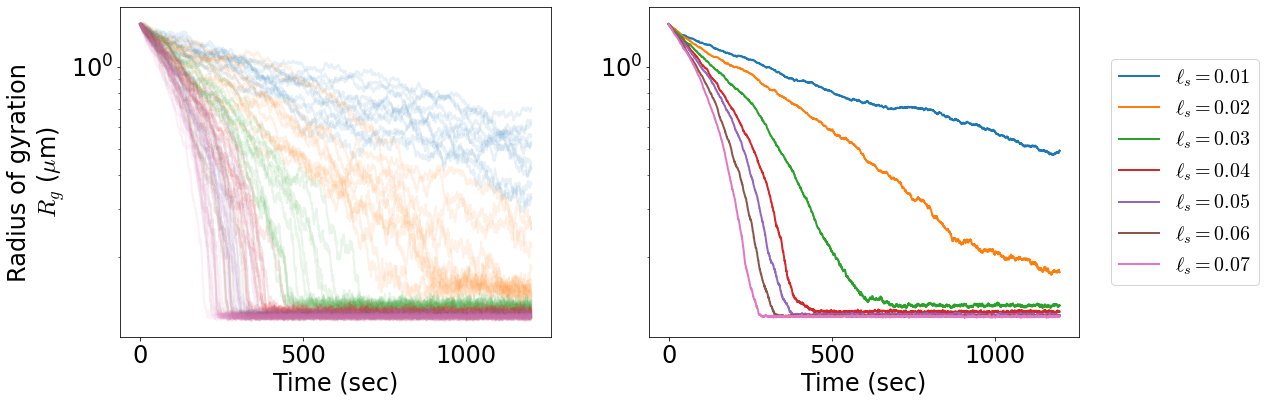

In [7]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_ee_list = []
    std_ee_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        avg_ee_arrs = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            time_arr = h5_data['time'][ss_ind:end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            # ee_dist = aa.get_end_end_distance(com_arr)
            rog = aa.calc_rad_of_gyration(com_arr)
            _ = axarr1[0].plot(time_arr, rog, color=colors[i], alpha=.1)
            avg_ee_arrs += [rog.tolist()]
        min_length = min([len(avg) for avg in avg_ee_arrs])
        
        
        avg_ee_arrs = np.array([avg[:min_length] for avg in avg_ee_arrs])
        avg_ee_list += [avg_ee_arrs.mean(axis=0)]
        std_ee_list += [avg_ee_arrs.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_ee_list[-1], color=colors[i], label=f"$\ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Radius of gyration\n' + r'$R_g$ ($\mu$m)')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

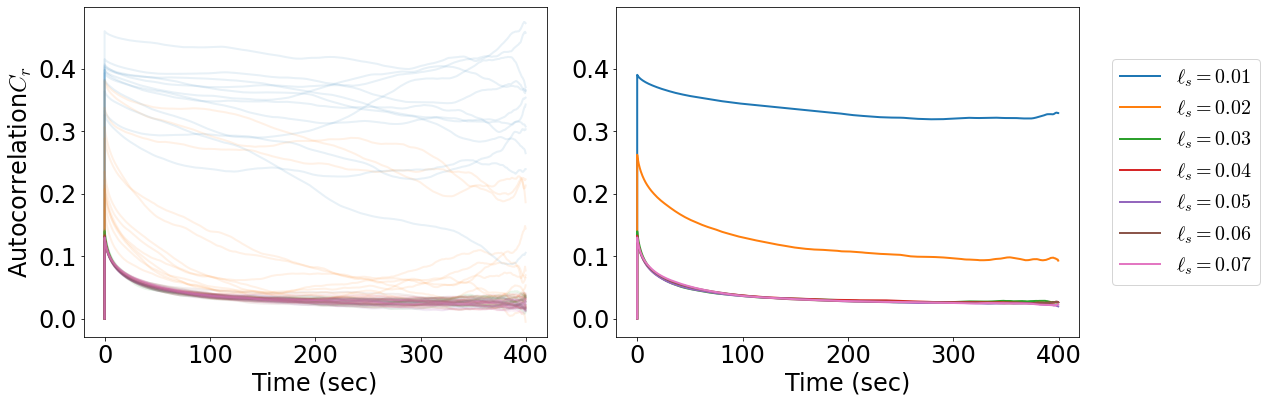

In [10]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in tqdm(sd_h5_data_lst):

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [sep_autocorr(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('Autocorrelation' + r'$ C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    # _ = axarr1[0].set_yscale('log')
    # _ = axarr1[0].set_ylim(0.1)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

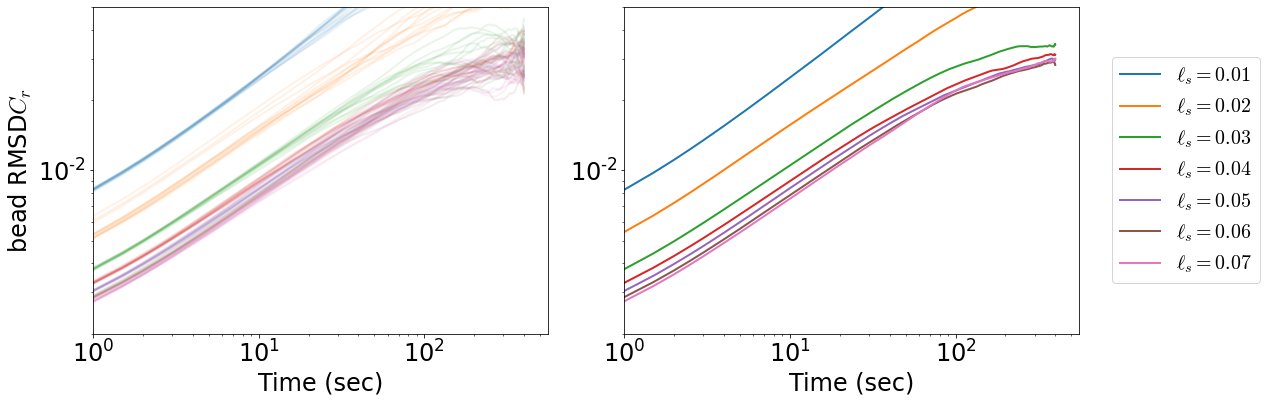

In [9]:
data_path = (ceph_path /"CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations")
colors = list(mcolors.TABLEAU_COLORS.keys())
ss_ind = 1600
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 2, figsize=(18, 6))
    axarr1[0].sharey(axarr1[1])
    axarr1[0].sharex(axarr1[1])
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:

            time_arr = h5_data['time'][:-ss_ind+end_ind]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_bead_rmsd(com_arr)]
            _ = axarr1[0].plot(time_arr, auto_corr_list[-1].cpu(), color=colors[i], alpha=.1)
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(axis=0)]
        std_auto_corr_list += [auto_corr_mat.std(axis=0)]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1[1].plot(time_arr[:min_length], avg_auto_corr_list[-1].cpu(), color=colors[i], label=f"$ \ell_s = {label}$")
    
    _ = axarr1[0].set_ylabel('bead RMSD' + r'$C_r$')
    _ = axarr1[0].set_xlabel('Time (sec)')
    _ = axarr1[1].set_xlabel('Time (sec)')
    _ = axarr1[0].set_yscale('log')
    _ = axarr1[0].set_xscale('log')
    _ = axarr1[0].set_ylim(0.002, .05)
    _ = axarr1[0].set_xlim(1.0)

    _ = axarr1[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()